In [9]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
from matplotlib import pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display, clear_output

import folium
from folium.plugins import MarkerCluster

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, mean_absolute_percentage_error
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
# from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from scipy import stats
from scipy.stats import skew
import matplotlib.ticker as ticker

In [2]:
df = pd.read_csv('Brazilian_ecommerce (merged).csv', index_col = 0)

for col in df.columns:
    if col.endswith('_timestamp') or col.endswith('_date') or col.endswith('_at'):
        try:
            if col.endswith('_timestamp'):
                df[col] = pd.to_datetime(df[col])
            elif col.endswith('_date') or col.endswith('_at'):
                df[col] = pd.to_datetime(df[col])
                # df[col] = pd.to_datetime(df[col]).dt.to_period('M')
        except Exception as e:
            print(f'Error mengonversi kolom {col}: {e}')
            pass

display(df.info())
display(df.head(2))

<class 'pandas.core.frame.DataFrame'>
Index: 96884 entries, 1 to 99693
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    96884 non-null  object        
 1   customer_unique_id             96884 non-null  object        
 2   order_id                       96884 non-null  object        
 3   seller_id                      96884 non-null  object        
 4   product_cat_name               96884 non-null  object        
 5   order_item_count               96884 non-null  int64         
 6   shipping_limit_date            96884 non-null  datetime64[ns]
 7   price                          96884 non-null  float64       
 8   freight_value                  96884 non-null  float64       
 9   payment_value                  96884 non-null  float64       
 10  payment_type                   96884 non-null  object        
 11  payment_installments

None

,customer_id,customer_unique_id,order_id,seller_id,product_cat_name,order_item_count,shipping_limit_date,price,freight_value,payment_value,payment_type,payment_installments,payment_sequential,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_creation_date,review_answer_timestamp,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,1,2017-05-03,239.9,19.93,259.83,credit_card,3,1,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04,2017-05-12,2017-05-15,4,2017-05-13,2017-05-15 11:34:13,15775,santa fe do sul,SP,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,furniture_decor,1,2018-01-18,199.0,17.87,216.87,credit_card,5,1,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16,2018-01-22,2018-02-05,5,2018-01-23,2018-01-23 16:06:31,35661,para de minas,MG,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556


# **K Means Clustering**

In [3]:
df_kmeans = df.copy()

# Count shipping time differencing
df_kmeans['shipping_time']           = abs(df_kmeans['order_delivered_carrier_date'] - df_kmeans['order_delivered_customer_date']).dt.days
df_kmeans['estimated_shipping_time'] = abs(df_kmeans['order_delivered_carrier_date'] - df_kmeans['order_estimated_delivery_date']).dt.days
df_kmeans['limit_shipping_time']     = abs(df_kmeans['order_delivered_carrier_date'] - df_kmeans['shipping_limit_date']).dt.days

df_kmeans['year_month'] = df_kmeans['order_purchase_timestamp'].dt.to_period('M')

# Drop datetime columns
datetime_cols = [col for col in df_kmeans.columns if col.endswith(('_timestamp', '_at', '_date'))]
df_kmeans.drop(columns = datetime_cols, inplace = True)

# display(df_kmeans.info())
display(df_kmeans.head(2))

,customer_id,customer_unique_id,order_id,seller_id,product_cat_name,order_item_count,price,freight_value,payment_value,payment_type,payment_installments,payment_sequential,order_status,review_score,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,shipping_time,estimated_shipping_time,limit_shipping_time,year_month
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,1,239.9,19.93,259.83,credit_card,3,1,delivered,4,15775,santa fe do sul,SP,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045,8,11,1,2017-04
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,furniture_decor,1,199.0,17.87,216.87,credit_card,5,1,delivered,5,35661,para de minas,MG,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556,6,20,2,2018-01


## **Feature Selection**

In [91]:
df_kmeans_grp = df_kmeans.groupby(['year_month', 'seller_id']).agg(
    customers = ('customer_unique_id', 'nunique'),
    orders = ('order_id', 'nunique'),
    revenue = ('payment_value', 'sum'),
    products = ('product_cat_name', 'nunique'),
    cities = ('customer_city', 'nunique'),
    item_count = ('order_item_count', 'sum'),
    avg_shipping_time = ('shipping_time', 'mean'),
    avg_review_score = ('review_score', 'mean'),
).round(2).reset_index()

df_kmeans_grp.head()

,year_month,seller_id,customers,orders,revenue,products,cities,item_count,avg_shipping_time,avg_review_score
0,2016-10,011b0eaba87386a2ae96a7d32bb531d1,1,1,129.16,1,1,2,10.0,4.0
1,2016-10,01cf7e3d21494c41fb86034f2e714fa1,1,1,89.16,1,1,1,1.0,5.0
2,2016-10,024b564ae893ce8e9bfa02c10a401ece,1,1,625.20,1,1,6,5.0,5.0
3,2016-10,0307f7565ff85b299b6e5ef162b1b1a9,1,1,27.86,1,1,1,1.0,2.0
4,2016-10,0336182e1b3e92f029d5354832045fdf,1,1,162.39,1,1,2,3.0,2.0


In [7]:
df_kmeans_grp['growth_rate'] = df_kmeans_grp.groupby('seller_id')['orders'].pct_change().round(2) * 100

df_kmeans_seller = df_kmeans_grp.groupby('seller_id').agg(
    avg_growth_rate = ('growth_rate', 'mean'),
    order_volume = ('orders', 'sum'),
    total_revenue = ('revenue', 'sum'),
    active_months = ('year_month', 'nunique'),
    avg_shipping_time = ('avg_shipping_time', 'mean'),
    avg_review_score = ('avg_review_score', 'mean'),
    products = ('products', 'first'),
    cities = ('cities', 'first')
).reset_index().fillna(0)

X = df_kmeans_seller[['avg_growth_rate', 'order_volume', 'total_revenue', 'active_months', 'avg_review_score', 'avg_shipping_time']].values
df_kmeans_seller.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835 entries, 0 to 2834
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seller_id          2835 non-null   object 
 1   avg_growth_rate    2835 non-null   float64
 2   order_volume       2835 non-null   int64  
 3   total_revenue      2835 non-null   float64
 4   active_months      2835 non-null   int64  
 5   avg_shipping_time  2835 non-null   float64
 6   avg_review_score   2835 non-null   float64
 7   products           2835 non-null   int64  
 8   cities             2835 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 199.5+ KB


In [92]:
df_kmeans_seller_active = df_kmeans_seller[df_kmeans_seller.active_months > 1].round(2).select_dtypes([int, float])
df_kmeans_seller_active

,avg_growth_rate,order_volume,total_revenue,active_months,avg_shipping_time,avg_review_score,products,cities
0,100.00,3,2748.06,2,7.50,4.00,1,1
1,4.06,192,32822.62,17,11.15,4.08,1,4
2,21.86,50,2169.64,8,11.57,3.79,1,3
4,18.94,152,23291.55,17,13.30,4.12,1,6
5,11.86,13,1372.43,8,6.94,3.33,1,1
...,...,...,...,...,...,...,...,...
2830,66.67,27,1950.22,7,10.13,4.28,5,5
2831,18.30,18,2828.66,11,6.21,4.39,1,1
2832,43.00,14,2259.55,7,10.62,3.89,1,1
2833,39.08,56,11283.42,14,11.34,3.74,1,2


## **3. Hyperparameter Tuning**

1. `Elbow Method`

> Suitable for Determining the Number of Clusters: The Elbow Method is a common technique used to identify the optimal number of clusters in K-Means. This method involves measuring the total **within-cluster sum of squares (WCSS)**  for various cluster counts and then looking for the "elbow" point on the plot.

2. `Grid Search CV`

> Suitable for Hyperparameter Tuning: GridSearchCV is used to find the best combination of hyperparameters for a model, including **K-Means**. This can include various cluster counts, initialization methods, and more.

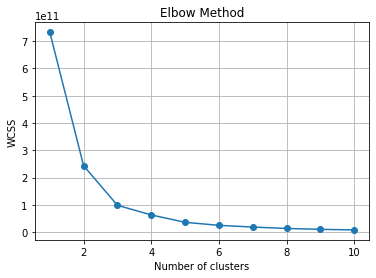

In [93]:
# Elbow Method

X = df_kmeans_seller_active.select_dtypes([float, int]).values

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize = (6, 4))
plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [101]:
# Grid Search

optimal_clusters = 3

param_grid = {
    'n_clusters': [optimal_clusters],
    'init': ['k-means++', 'random'],
    'max_iter': list(range(10, 101, 10)),
    'n_init': [10, 20]
}

def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

kmeans = KMeans()
grid_search = GridSearchCV(estimator = kmeans, param_grid = param_grid, cv = 3, scoring = silhouette_scorer)

grid_search.fit(X)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

best_kmeans = KMeans(**grid_search.best_params_)
best_kmeans.fit(X)

labels = best_kmeans.labels_
df_kmeans_seller_active['cluster'] = labels

Best Parameters: {'init': 'k-means++', 'max_iter': 10, 'n_clusters': 3, 'n_init': 10}
Best Score: 0.8570538889104663


,avg_growth_rate,order_volume,total_revenue,active_months,avg_shipping_time,avg_review_score,products,cities
cluster,,,,,,,,
0,41.70,24.58,3593.84,6.31,8.49,4.18,1.18,2.09
1,50.53,998.28,170995.44,17.67,9.59,4.15,1.78,10.33
2,58.37,227.42,40839.70,14.37,9.39,4.12,1.50,4.76


C:\Users\benjamin\AppData\Local\Temp\ipykernel_9152\1472841063.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label=f'Cluster {label}')


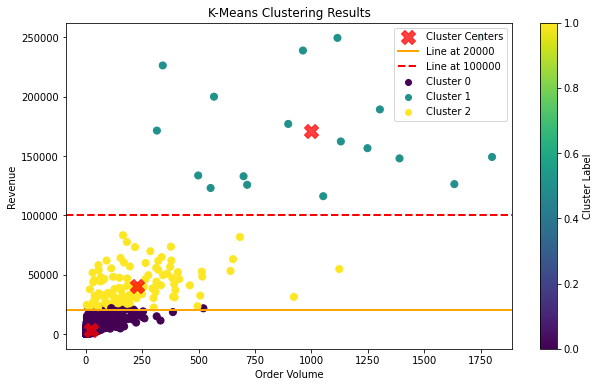

In [110]:
seller_cluster = df_kmeans_seller_active.groupby('cluster').mean().round(2)
display(seller_cluster)

plt.figure(figsize=(10, 6))

# Plot scatter
scatter = plt.scatter(X[:, 1], 
                      X[:, 2], 
                      c=labels, s=50, cmap='viridis')

# Plot pusat cluster
plt.scatter(best_kmeans.cluster_centers_[:, 1], best_kmeans.cluster_centers_[:, 2],
            c='red', s=200, alpha=0.75, marker='X', label='Cluster Centers')

# Menambahkan garis vertikal
plt.axhline(y=20000, color='orange', linestyle='-', label='Line at 20000', linewidth = 2)
plt.axhline(y=100000, color='r', linestyle='--', label='Line at 100000', linewidth = 2)

# Menampilkan label untuk cluster
unique_labels = set(labels)
for label in unique_labels:
    plt.scatter([], [], c=scatter.cmap(scatter.norm(label)), label=f'Cluster {label}')

# Menambahkan judul dan label
plt.title('K-Means Clustering Results')
plt.xlabel('Order Volume')
plt.ylabel('Revenue')
plt.colorbar(label='Cluster Label')

# Menampilkan legenda
plt.legend()
plt.show()

In [113]:
display(df_kmeans_seller_active.groupby('cluster').min())
display(df_kmeans_seller_active.groupby('cluster').max())

,avg_growth_rate,order_volume,total_revenue,active_months,avg_shipping_time,avg_review_score,products,cities
cluster,,,,,,,,
0,-93.00,2,50.83,2,0.50,1.00,1,1
1,14.06,315,116209.04,7,7.51,3.54,1,1
2,-45.75,4,22358.89,3,4.59,2.25,1,1


,avg_growth_rate,order_volume,total_revenue,active_months,avg_shipping_time,avg_review_score,products,cities
cluster,,,,,,,,
0,3100.00,521,22154.53,21,64.00,5.00,7,21
1,169.18,1800,250026.97,21,12.67,4.48,3,27
2,425.88,1123,83295.06,21,13.55,4.72,6,28


In [116]:
display(df_kmeans_seller_active.groupby('cluster').count())

,avg_growth_rate,order_volume,total_revenue,active_months,avg_shipping_time,avg_review_score,products,cities
cluster,,,,,,,,
0,2047,2047,2047,2047,2047,2047,2047,2047
1,18,18,18,18,18,18,18,18
2,110,110,110,110,110,110,110,110


In [115]:
df_kmeans_seller_active.skew()

avg_growth_rate      14.560836
order_volume          8.277018
total_revenue         7.778885
active_months         1.092112
avg_shipping_time     4.054354
avg_review_score     -1.291992
products              3.923001
cities                4.185984
cluster               3.916203
dtype: float64

In [207]:
silhouette_avg = silhouette_score(X, labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.8507096535634979


# **Linear Regression**

In [4]:
df_kmeans.head()

,customer_id,customer_unique_id,order_id,seller_id,product_cat_name,order_item_count,price,freight_value,payment_value,payment_type,payment_installments,payment_sequential,order_status,review_score,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,seller_zip_code_prefix,seller_city,seller_state,seller_lat,seller_lng,shipping_time,estimated_shipping_time,limit_shipping_time,year_month
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,1,239.90,19.93,259.83,credit_card,3,1,delivered,4,15775,santa fe do sul,SP,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045,8,11,1,2017-04
2,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,furniture_decor,1,199.00,17.87,216.87,credit_card,5,1,delivered,5,35661,para de minas,MG,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556,6,20,2,2018-01
3,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,perfumery,1,12.99,12.79,25.78,credit_card,2,1,delivered,4,12952,atibaia,SP,-23.104346,-46.595589,14403,franca,SP,-20.554951,-47.387691,4,10,5,2018-08
4,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,garden_tools,1,199.90,18.14,218.04,credit_card,3,1,delivered,5,13226,varzea paulista,SP,-23.245512,-46.825182,87900,loanda,PR,-22.930408,-53.136438,13,29,3,2017-02
5,816cbea969fe5b689b39cfc97a506742,85c835d128beae5b4ce8602c491bf385,00048cc3ae777c65dbb7d2a0634bc1ea,6426d21aca402a131fc0a5d0960a3c90,housewares,1,21.90,12.69,34.59,boleto,1,1,delivered,4,38017,uberaba,MG,-19.740324,-47.925353,14091,ribeirao preto,SP,-21.189678,-47.788330,5,20,6,2017-05


In [49]:
df_reglin = df_kmeans.copy()

df_reglin = df_kmeans.groupby(['year_month', 'seller_id', 'product_cat_name', 'customer_state', 'customer_city']).agg(
    customers = ('customer_unique_id', 'nunique'),
    order_volume = ('order_id', 'nunique'),
    price = ('price', 'sum'),
    freight_value = ('freight_value', 'sum'),
    revenue = ('payment_value', 'sum'),
    item_count = ('order_item_count', 'sum'),
    avg_shipping_time = ('shipping_time', 'mean'),
    avg_review_score = ('review_score', 'mean'),
).round(2).reset_index()

print(len(df_reglin))

df_reglin['growth_rate'] = df_reglin.groupby('seller_id')['revenue'].pct_change().round(2) * 100

df_reglin = df_reglin.groupby(['seller_id', 'product_cat_name', 'customer_state', 'customer_city']).agg(
    customers = ('customers', 'max'),
    order_volume = ('order_volume', 'sum'),
    price = ('price', 'sum'),
    freight_value = ('freight_value', 'sum'),
    revenue = ('revenue', 'sum'),
    item_count = ('item_count', 'sum'),
    avg_shipping_time = ('avg_shipping_time', 'mean'),
    avg_review_score = ('avg_review_score', 'mean'),
    avg_growth_rate = ('growth_rate', 'mean'),
).round(2).reset_index()

print(len(df_reglin))

df_reglin.rename(columns = {'product_cat_name' : 'product',
                  'customer_state': 'state',
                  'customer_city': 'city'},
                 inplace = True)

df_reglin[df_reglin.avg_growth_rate > 0].sample(5)

82271
63618


,seller_id,product,state,city,customers,order_volume,price,freight_value,revenue,item_count,avg_shipping_time,avg_review_score,avg_growth_rate
57656,e9779976487b77c6d4ac45f75ec7afe9,sports_leisure,RS,sarandi,1,1,34.49,15.10,49.59,1,9.0,5.0,12.0
52942,d91fb3b7d041e83b64a00a3edfb37e4f,home_appliances,MG,barroso,1,1,84.00,18.47,102.47,1,7.0,5.0,153.0
33389,8160255418d5aaa7dbdc9f4c64ebda44,bed_bath_table,MG,uberaba,1,1,109.90,18.02,127.92,1,5.0,5.0,3.0
53891,da8622b14eb17ae2831f4ac5b9dab84a,bed_bath_table,SP,embu-guacu,1,1,299.70,36.57,336.27,3,4.0,4.0,107.0
14549,3d871de0142ce09b7081e2b9d1733cb1,stationery,SP,bauru,1,2,287.00,63.18,350.18,3,6.0,3.5,27.0


In [121]:
results, mape_results  = [], []

freight_discounts = range(0, 101, 10)
product_discounts = [0, 10, 20, 30]

for f_d in freight_discounts:
    for p_d in product_discounts:
        total_discount = (f_d * 2) + (p_d * 4)
        
        discounted_freight_value = df_reglin['freight_value'] * (1 - f_d / 100)
        discounted_price = df_reglin['price'] * (1 - p_d / 100)
        
        new_order_volume = df_reglin['order_volume'] * (1 + total_discount / 100) * 2

        X = pd.DataFrame({
            'price': discounted_price,
            'order_volume': new_order_volume,
            'freight_value': discounted_freight_value,
        })
        y = df_reglin['revenue']

        model = LinearRegression()
        model.fit(X, y)
        
        predicted_revenue = model.predict(X)
        
        mape = np.mean(np.abs((y - predicted_revenue) / y)) * 100  
        mape_results.append({
            'freight_discount': f_d,
            'product_discount': p_d,
            'mape': mape
        })

        for i in range(len(df_reglin)):
            results.append({
                'seller_id': df_reglin['seller_id'][i],
                'product': df_reglin['product'][i],
                'state': df_reglin['state'][i],
                'predicted_revenue': predicted_revenue[i],
                'actual_revenue': df_reglin['revenue'][i],  
                'revenue_difference': predicted_revenue[i] - df_reglin['revenue'][i],
                'freight_discount': f_d,
                'product_discount': p_d
            })

results_df = pd.DataFrame(results)

grouped_by_seller = results_df.groupby(['seller_id', 'freight_discount', 'product_discount']).agg(
    total_revenue=('predicted_revenue', 'sum'),
    total_actual_revenue=('actual_revenue', 'sum'),
    total_difference=('revenue_difference', 'sum')
).reset_index()

grouped_by_product = results_df.groupby(['product', 'freight_discount', 'product_discount']).agg(
    total_revenue=('predicted_revenue', 'sum'),
    total_actual_revenue=('actual_revenue', 'sum'),
    total_difference=('revenue_difference', 'sum')
).reset_index().sort_values(by = ['product', 'total_difference'],
                            ascending = False).drop_duplicates(subset = 'product')

grouped_by_state = results_df.groupby(['state', 'freight_discount', 'product_discount']).agg(
    total_revenue=('predicted_revenue', 'sum'),
    total_actual_revenue=('actual_revenue', 'sum'),
    total_difference=('revenue_difference', 'sum')
).reset_index().sort_values(by = ['state', 'total_difference'],
                            ascending = False).drop_duplicates(subset = 'state')

print("Total Revenue by Seller:")
print(grouped_by_seller)

print("\nTotal Revenue by Product:")
print(grouped_by_product)

print("\nTotal Revenue by State:")
print(grouped_by_state)

top_products = grouped_by_product.sort_values(by = 'total_difference', ascending = False).head(10).round(2)
top_states = grouped_by_state.sort_values(by = 'total_difference', ascending = False).head(10).round(2)

print("\nTop 10 Products by Revenue:")
display(top_products)

print("\nTop 10 States by Revenue:")
display(top_states)

Total Revenue by Seller:
                               seller_id  freight_discount  product_discount  \
0       0015a82c2db000af6aaaf3ae2ecb0532                 0                 0   
1       0015a82c2db000af6aaaf3ae2ecb0532                 0                10   
2       0015a82c2db000af6aaaf3ae2ecb0532                 0                20   
3       0015a82c2db000af6aaaf3ae2ecb0532                 0                30   
4       0015a82c2db000af6aaaf3ae2ecb0532                10                 0   
...                                  ...               ...               ...   
124735  ffff564a4f9085cd26170f4732393726                90                30   
124736  ffff564a4f9085cd26170f4732393726               100                 0   
124737  ffff564a4f9085cd26170f4732393726               100                10   
124738  ffff564a4f9085cd26170f4732393726               100                20   
124739  ffff564a4f9085cd26170f4732393726               100                30   

        total_

,product,freight_discount,product_discount,total_revenue,total_actual_revenue,total_difference
3252,watches_gifts,100,0,1300171.48,1266169.20,34002.28
1976,health_beauty,100,0,1420772.98,1392582.64,28190.34
3165,telephony,100,10,403059.17,375566.50,27492.67
2725,perfumery,100,10,423785.75,404468.64,19317.11
1273,fashion_bags_accessories,100,10,187176.81,173002.62,14174.19
261,auto,100,10,667581.89,654295.37,13286.52
3209,toys,100,10,539568.18,528632.21,10935.97
1185,electronics,100,10,194938.78,184470.31,10468.47
3033,sports_leisure,100,10,1094911.94,1085352.07,9559.87
746,consoles_games,100,20,167829.93,158858.43,8971.50



Top 10 States by Revenue:


,state,freight_discount,product_discount,total_revenue,total_actual_revenue,total_difference
1140,SP,100,0,5892135.42,5717531.43,174603.99
201,BA,60,10,575230.41,570290.43,4939.98
481,MG,100,10,1797406.03,1792715.53,4690.50
321,ES,30,10,306153.90,302936.54,3217.36
685,PE,60,10,306746.25,304184.37,2561.88
789,PR,100,10,771013.76,769719.00,1294.76
640,PB,60,0,130976.93,129933.34,1043.59
728,PI,60,0,102040.12,101002.32,1037.80
68,AL,60,0,92872.46,91932.76,939.70
871,RN,80,30,98686.57,97786.92,899.65


In [124]:
pd.DataFrame(mape_results).mape.mean()

8.890863037848892

In [128]:
pd.DataFrame(mape_results)

,freight_discount,product_discount,mape
0,0,0,8.257163
1,0,10,8.257163
2,0,20,8.257163
3,0,30,8.257163
4,10,0,8.257163
...,...,...,...
39,90,30,8.257163
40,100,0,15.227859
41,100,10,15.227859
42,100,20,15.227859


In [100]:
top_products

,product,freight_discount,product_discount,total_revenue,total_actual_revenue,total_difference
3252,watches_gifts,100,0,1300171.48,1266169.20,34002.28
1976,health_beauty,100,0,1420772.98,1392582.64,28190.34
3165,telephony,100,10,403059.17,375566.50,27492.67
2725,perfumery,100,10,423785.75,404468.64,19317.11
1273,fashion_bags_accessories,100,10,187176.81,173002.62,14174.19
261,auto,100,10,667581.89,654295.37,13286.52
3209,toys,100,10,539568.18,528632.21,10935.97
1185,electronics,100,10,194938.78,184470.31,10468.47
3033,sports_leisure,100,10,1094911.94,1085352.07,9559.87
746,consoles_games,100,20,167829.93,158858.43,8971.50


,product,freight_discount,product_discount,total_revenue,total_actual_revenue,total_difference
1976,health_beauty,100,0,1420772.98,1392582.64,28190.34
3252,watches_gifts,100,0,1300171.48,1266169.20,34002.28
3033,sports_leisure,100,10,1094911.94,1085352.07,9559.87
261,auto,100,10,667581.89,654295.37,13286.52
3209,toys,100,10,539568.18,528632.21,10935.97
2725,perfumery,100,10,423785.75,404468.64,19317.11
3165,telephony,100,10,403059.17,375566.50,27492.67
1185,electronics,100,10,194938.78,184470.31,10468.47
1273,fashion_bags_accessories,100,10,187176.81,173002.62,14174.19
746,consoles_games,100,20,167829.93,158858.43,8971.50


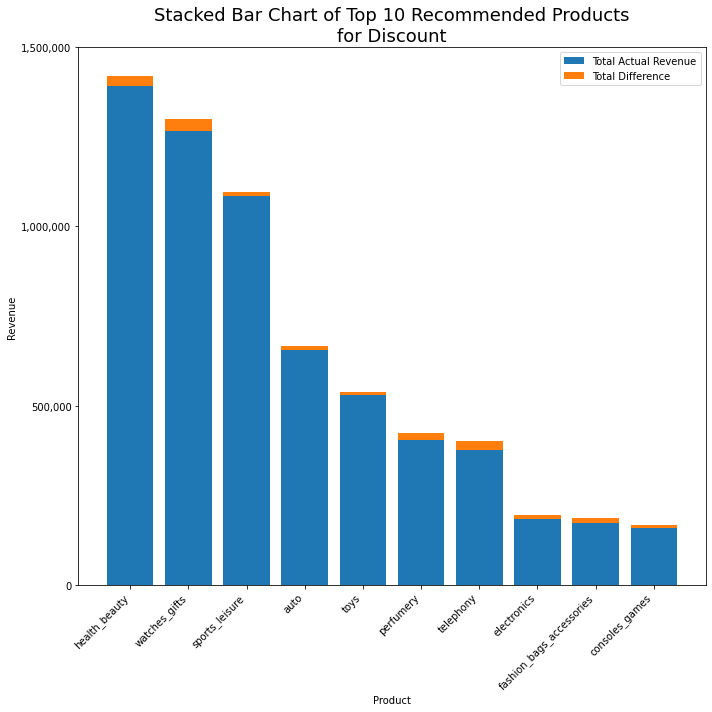

In [101]:
top_products.sort_values(by = 'total_revenue', 
                         ascending = False,
                         inplace = True)

display(top_products)

plt.figure(figsize=(10, 10))

plt.bar(top_products['product'], top_products['total_actual_revenue'], label='Total Actual Revenue')
plt.bar(top_products['product'], top_products['total_difference'], 
        bottom=top_products['total_actual_revenue'], label='Total Difference')

plt.xlabel('Product')
plt.ylabel('Revenue')
plt.title('Stacked Bar Chart of Top 10 Recommended Products\nfor Discount', fontsize = 18)
plt.xticks(rotation=45, ha='right')
plt.yticks([0, 500000, 1000000, 1500000])
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()

plt.tight_layout()
plt.show()

In [102]:
grouped_by_state[grouped_by_state.total_difference > 0].round(2)

,state,freight_discount,product_discount,total_revenue,total_actual_revenue,total_difference
1140,SP,100,0,5892135.42,5717531.43,174603.99
1080,SE,60,0,68719.64,68195.06,524.58
871,RN,80,30,98686.57,97786.92,899.65
789,PR,100,10,771013.76,769719.00,1294.76
728,PI,60,0,102040.12,101002.32,1037.80
685,PE,60,10,306746.25,304184.37,2561.88
640,PB,60,0,130976.93,129933.34,1043.59
481,MG,100,10,1797406.03,1792715.53,4690.50
321,ES,30,10,306153.90,302936.54,3217.36
244,CE,60,0,263277.49,262759.48,518.01


In [103]:
grouped_by_product.product_discount.value_counts()

product_discount
10    47
0     21
20     3
30     3
Name: count, dtype: int64

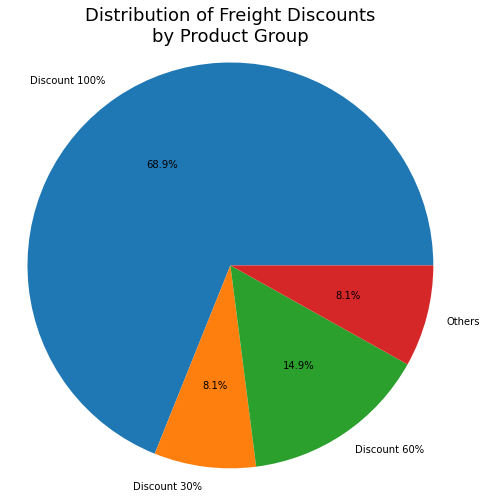

In [116]:
product_shipment_disc = pd.DataFrame(grouped_by_product.freight_discount.value_counts()).reset_index()

product_shipment_disc['freight_discount'] = product_shipment_disc['freight_discount'].astype(str)
product_shipment_disc.loc[product_shipment_disc['freight_discount'].isin(['10', '50', '80', '90']), 'freight_discount'] = 'Others'

product_shipment_disc.replace({
    '100' : 'Discount 100%',
    '60' : 'Discount 60%',
    '30' : 'Discount 30%',
}, inplace = True)

product_shipment_disc_grouped = product_shipment_disc.groupby('freight_discount')['count'].sum().reset_index()

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.pie(product_shipment_disc_grouped['count'], labels=product_shipment_disc_grouped['freight_discount'], autopct='%1.1f%%', startangle=0)
plt.title('Distribution of Freight Discounts\nby Product Group', fontsize = 18)
plt.axis('equal')  
plt.show()

In [108]:
product_shipment_disc

,freight_discount,count
0,100,51
1,60,11
2,30,6
3,80,2
4,10,2
5,50,1
6,90,1


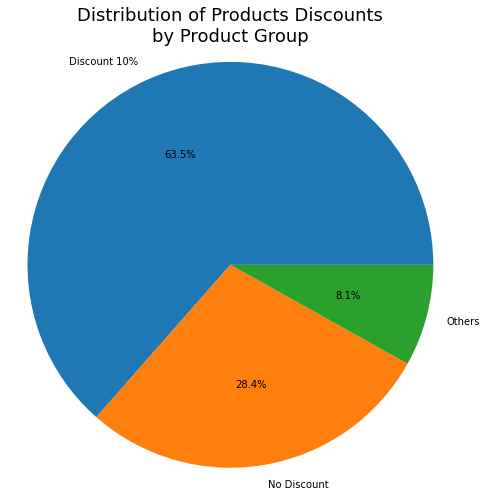

In [120]:
product_shipment_disc = pd.DataFrame(grouped_by_product.product_discount.value_counts()).reset_index()

product_shipment_disc['product_discount'] = product_shipment_disc['product_discount'].astype(str)
product_shipment_disc.loc[product_shipment_disc['product_discount'].isin(['30', '20']), 'product_discount'] = 'Others'

product_shipment_disc.replace({
    '0' : 'No Discount',
    '10' : 'Discount 10%'
}, inplace = True)

product_shipment_disc_grouped = product_shipment_disc.groupby('product_discount')['count'].sum().reset_index()

plt.figure(figsize=(8, 8), facecolor = 'white')
plt.pie(product_shipment_disc_grouped['count'], labels=product_shipment_disc_grouped['product_discount'], autopct='%1.1f%%', startangle=0)
plt.title('Distribution of Products Discounts\nby Product Group', fontsize = 18)
plt.axis('equal')  
plt.show()

,product,freight_discount,product_discount,total_revenue,total_actual_revenue,total_difference
1,health_beauty,100,0,1420772.98,1392582.64,28190.34
0,watches_gifts,100,0,1300171.48,1266169.20,34002.28
3,cool_stuff,100,0,673359.68,667372.51,5987.17
2,computers,100,0,226330.33,218079.21,8251.12
7,musical_instruments,100,0,197811.83,197531.17,280.66
5,small_appliances,100,0,197077.18,196063.63,1013.55
6,agro_industry_and_commerce,100,0,77013.74,76006.20,1007.54
4,fixed_telephony,100,0,55836.33,54264.83,1571.50
8,portable_kitchen_and_food_preparation_tools,100,0,4276.78,4228.05,48.73


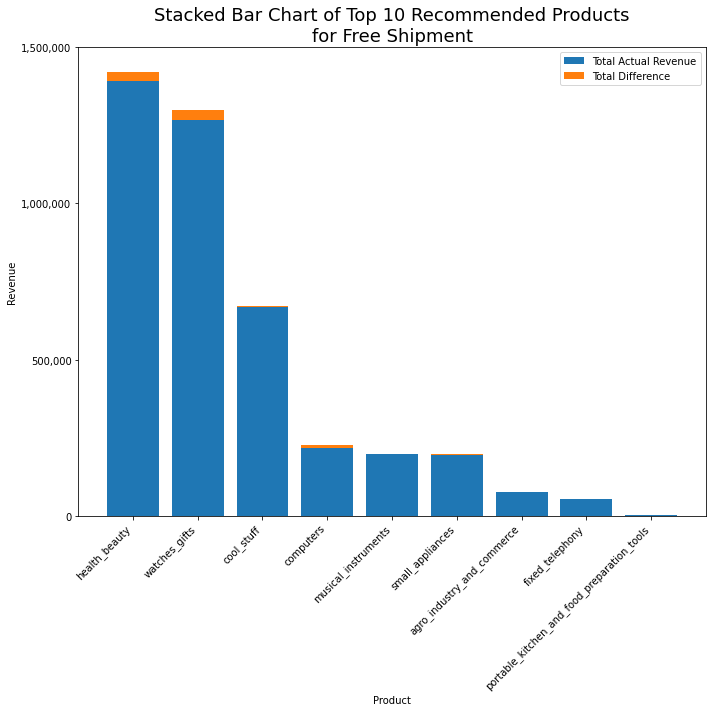

In [85]:
product_free_shipment = grouped_by_product[
    (grouped_by_product.freight_discount == 100) & 
    (grouped_by_product.product_discount == 0) &
    (grouped_by_product.total_difference >= 0)
    ].sort_values(
    by = 'total_difference', 
    ascending = False
).round(2).reset_index(drop = True).sort_values(by = 'total_revenue', ascending = False)

display(product_free_shipment)

plt.figure(figsize=(10, 10))

plt.bar(product_free_shipment['product'], product_free_shipment['total_actual_revenue'], label='Total Actual Revenue')
plt.bar(product_free_shipment['product'], product_free_shipment['total_difference'], 
        bottom=product_free_shipment['total_actual_revenue'], label='Total Difference')

plt.xlabel('Product')
plt.ylabel('Revenue')
plt.title('Stacked Bar Chart of Top 10 Recommended Products\nfor Free Shipment', fontsize = 18)
plt.xticks(rotation=45, ha='right')
plt.yticks([0, 500000, 1000000, 1500000])
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()

plt.tight_layout()
plt.show()

In [131]:
grouped_by_product[grouped_by_product.product_discount == 30]

,product,freight_discount,product_discount,total_revenue,total_actual_revenue,total_difference
2071,industry_commerce_and_business,80,30,4.532287e+04,46112.10,-789.228917
639,computers_accessories,100,30,1.024304e+06,1033849.23,-9545.170826
311,bed_bath_table,80,30,1.245043e+06,1278831.83,-33789.285170
199,audio,100,30,6.001914e+04,57486.11,2533.028781


In [66]:
X = df_reglin[['freight_value', 'order_volume', 'price']]
y = df_reglin['revenue']  

model = LinearRegression()
model.fit(X, y)

discounts = range(10, 51, 10)
results = []

for discount in discounts:
    discounted_freight = df_reglin['freight_value'] * (1 - discount / 100)
    
    increase_factor = 1 + (discount * 5 / 100) * 5
    new_order_volume = df_reglin['order_volume'] * increase_factor
    
    new_X = pd.DataFrame({
        'freight_value': discounted_freight,
        'order_volume': new_order_volume,
        'price': df_reglin['price'] 
    })
    
    new_revenue = model.predict(new_X)
    
    df_reglin[f'revenue_disc_{discount}'] = new_revenue
    
    results.append({
        'discount_percentage': discount,
        'predicted_revenue': new_revenue.sum(),
        'original_revenue': df_reglin['revenue'].sum(),
        'revenue_difference': new_revenue.sum() - df_reglin['revenue'].sum()
    })

results_df = pd.DataFrame(results).round(2)

display(results_df)

,discount_percentage,predicted_revenue,original_revenue,revenue_difference
0,10,15505042.22,15171864.38,333177.84
1,20,15838220.06,15171864.38,666355.68
2,30,16171397.89,15171864.38,999533.51
3,40,16504575.73,15171864.38,1332711.35
4,50,16837753.57,15171864.38,1665889.19
